**Basic Setup**

In [2]:
# Import packages
import deeplake
import librosa
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib as mpl
import matplotlib.pyplot as plt

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
# Configure matplotlib
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
# To make this notebook's output stable across runs
np.random.seed(42)

In [5]:
def standardize_mfcc_length(mfcc_list, target_length=100):
    """Standardize MFCC matrices to a fixed length"""
    result = []
    for mfcc in mfcc_list:
        current_length = mfcc.shape[1]
        if current_length > target_length:
            # Truncate if longer than target
            standardized = mfcc[:, :target_length]
        else:
            # Pad with zeros if shorter
            padding = np.zeros((mfcc.shape[0], target_length - current_length))
            standardized = np.hstack([mfcc, padding])
        
        # Flatten the matrix for traditional ML models
        result.append(standardized.flatten())
    
    return np.array(result)

In [6]:
TARGET_LABELS = {"stop", "go", "up", "down", "left", "right"}

def extract_filtered_mfcc_features(dataset, n_mfcc=13, sample_rate=16000):
    """
    Extracts MFCC features only for the selected words.
    
    Parameters:
    - dataset: The Deeplake dataset containing audio tensors.
    - n_mfcc: Number of MFCC coefficients to extract.
    - sample_rate: Target sample rate for librosa processing.
    
    Returns:
    - X: NumPy array of MFCC features (num_samples, n_mfcc)
    - y: NumPy array of corresponding labels
    """
    
    X, y = [], []
    
    for i in range(len(dataset)):
        point_label = dataset.labels[i].data()['text'][0]  

        if point_label in TARGET_LABELS:  # Keep only target samples
            
            audio = dataset['audios'][i].numpy().squeeze()  # Extract audio data
            
            # Compute MFCC
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
            # mfcc_mean = np.mean(mfcc, axis=1)  # second method: Can take mean of factors for more simplistic feature set
            
            X.append(mfcc)
            y.append(point_label)
            
    return standardize_mfcc_length(X), np.array(y)

In [7]:
# Load the dataset
print("Loading dataset...")
dataset= deeplake.load('hub://activeloop/speech-commands-train')

# print(dataset.labels[1].data()['text'])

#  Note, while there is a testing dataset, it does not have any labels.

Loading dataset...


Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/speech-commands-train



|

hub://activeloop/speech-commands-train loaded successfully.



In [8]:
# Extract all labels as a list
all_labels = [dataset.labels[i].data()['text'][0] for i in range(len(dataset))]

# Count occurrences of each unique label
label_counts = {label: all_labels.count(label) for label in np.unique(all_labels)}

# Convert to a Pandas DataFrame
df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])

# Display the table
display(df)

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


,Label,Count
0,_background_noise_,6
1,bed,1713
2,bird,1731
3,cat,1733
4,dog,1746
5,down,2359
6,eight,2352
7,five,2357
8,four,2372
9,go,2372


In [9]:
# Extract features only from the training dataset
print("Extracting filtered MFCC features from training set...")
X, y = extract_filtered_mfcc_features(dataset)



# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Feature extraction complete.")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Extracting filtered MFCC features from training set...


c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(
c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Feature extraction complete.
Train data shape: (11364, 1300)
Test data shape: (2842, 1300)


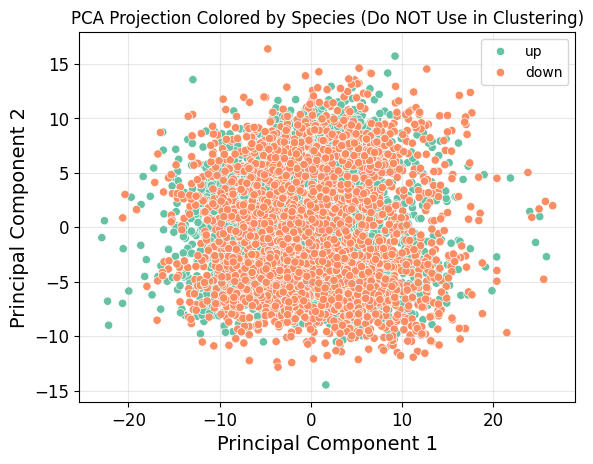

In [ ]:
# Use PCA to visualize data in lower dimension
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
# import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Keep only rows where y is 'down' or 'up'
mask = np.isin(y, ["down", "up"])

X_filtered = X_scaled[mask]
y_filtered = y[mask]


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_filtered, palette='Set2')
plt.title("PCA Projection Colored by Species (Do NOT Use in Clustering)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)



In [10]:
# Train Logistic Regression Model
print("Training logistic regression model...")
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)

Training logistic regression model...


c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=100000)

In [11]:
# Evaluate the model
print("Evaluating model...")
y_pred = model.predict(X_test)

# Display evaluation metrics
print("\nUntuned Logist Regression Model Performance:")
print(classification_report(y_test, y_pred))

Evaluating model...

Untuned Logist Regression Model Performance:
              precision    recall  f1-score   support

        down       0.59      0.61      0.60       472
          go       0.60      0.60      0.60       475
        left       0.58      0.56      0.57       471
       right       0.67      0.65      0.66       473
        stop       0.70      0.70      0.70       476
          up       0.54      0.54      0.54       475

    accuracy                           0.61      2842
   macro avg       0.61      0.61      0.61      2842
weighted avg       0.61      0.61      0.61      2842



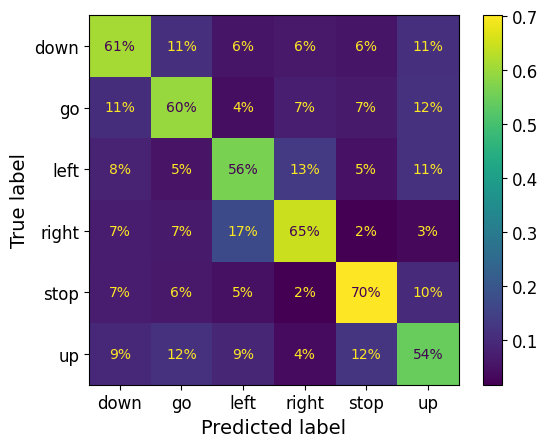

In [13]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()